In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import cm

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

【問題1】中心点の初期値を決める 
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。
最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。
K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

【問題2】SSEを求める関数の作成 
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。
K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。

【問題3】クラスタへの割り当て 
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。
K-menasにおける 近い とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。

【問題4】中心点の移動 
中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。
クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

【問題5】繰り返し 
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。
次のどれかの条件を満たしたらこれを止めます。
繰り返しが指定した回数に到達する。（雛形では引数max_iter）
中心点 $\mu_k$ と重心の差が指定した許容値以下になる。（雛形では引数tol）

【問題6】異なる初期値で計算 
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。

In [17]:
from statistics import mean, median,variance,stdev

class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, n_clusters, n_init=5, max_iter=100, tol=1e-3, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        
        self.m = None
        self.m_opt = None
        self.m_opt_sse = 0

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """
        self.m_opt = np.empty((self.n_clusters, X.shape[1]))
        self.m_opt_sse = self.calc_sse(X, self.m_opt)
        for _ in range(self.n_init):
            self.m = self.select_init(X)
            for _ in range(self.max_iter):
                m_temp = self.m.copy()
                self.move_m(X)
                if np.max(np.linalg.norm(m_temp - self.m, axis=1)) < self.tol:
                    break
            sse_temp = self.calc_sse(X, self.m)
            if self.m_opt_sse > sse_temp:
                self.m_opt = self.m
                self.m_opt_sse = sse_temp

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        return self.neighbor(X, self.m_opt)
    
    def select_init(self, X):
        """
        入力されたデータの中からランダムに選び、中心点の初期値を決める
        """
        idx = np.random.choice(np.arange(X.shape[0]), self.n_clusters, replace=False)
        return X[idx]
    
    def neighbor(self, X, m):
        """
        入力されたデータがどの中心点に一番近いかを計算
        """
        return np.argmin(np.linalg.norm(X - m.reshape(-1, 1, X.shape[1]), axis=2), axis=0)
    
    def move_m(self, X):
        """
        中心点を移動する。（1回）
        """
        for i in range(self.n_clusters):
            self.m[i] = np.mean(X[np.where(self.neighbor(X, self.m) == i)], axis=0)
            
    def calc_sse(self, X, m):
        return np.sum(np.min(np.linalg.norm(X - m.reshape(-1, 1, X.shape[1]), axis=2)**2, axis=0))

In [20]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

### 【問題7】推定 
新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。
データ点 Xnと学習で決まった中心点 μkに対し、 SSEを最小化する rnkを選ぶ。
具体的には次のことです。
データ点 Xnを最も近い μkに割り当てる。

In [22]:
src_kmeans = ScratchKMeans(5,10,2)
src_kmeans.fit(X)
src_kmeans.predict(X)
#a2 =np.array(list(src_kmeans.clus_dic.values()))
#a1 =np.array(list(src_kmeans.clus_dic_0.values()))
#aa=a2-a1
#display(aa)
#np.max(aa)
#display(src_kmeans.sse_lis)
#display(src_kmeans.x_class)

array([1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 4, 4, 0, 2, 4, 1, 3,
       2, 4, 1, 2, 0, 1, 4, 4, 4, 3, 4, 4, 2, 1, 3, 4, 3, 2, 1, 2, 3, 2,
       2, 3, 4, 2, 1, 0, 1, 4, 2, 2, 2, 3, 3, 4, 4, 3, 3, 4, 4, 1, 4, 3,
       2, 2, 4, 1, 3, 4, 1, 3, 1, 1, 0, 2, 4, 4, 4, 3, 2, 0, 4, 2, 4, 4,
       1, 1, 1, 2, 0, 2, 2, 3, 3, 2, 3, 0], dtype=int64)

### 【問題8】エルボー法の実装 
K-meansにおいて中心点の個数 kは人為的に決める必要がありますが、その判断方法としてエルボー法があります。
エルボー法により中心点の個数 kを検討するためのコードを作成してください。
SSEを縦軸、クラスタ数 kを横軸にした折れ線グラフを表示します。
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [24]:
def graph_elbow(X, count=8, n_init=10, max_iter=200, tol=1e-3, verbose=False):
    sse_array = np.empty(count)
    for i in range(count):
        _scratch_k_means = ScratchKMeans(n_clusters=i+1, n_init=n_init, max_iter=max_iter, tol=tol, verbose=verbose)
        _scratch_k_means.fit(X)
        sse_array[i] = _scratch_k_means.m_opt_sse

    plt.title("Elbow")
    plt.xlabel("n_clusters")
    plt.ylabel("SSE")
    plt.plot(np.arange(1, count+1), sse_array, label="SSE")
    plt.legend()
    plt.show()

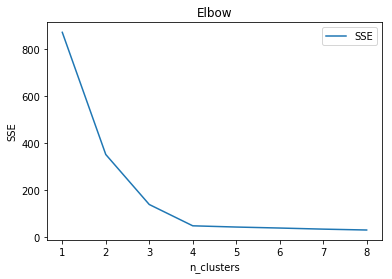

In [25]:
graph_elbow(X)

### 【問題10】クラスタ数kの選択 
最適だと思われるクラスタ数 kを選択してください。
エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。
選択した上で、なぜそれを選んだか説明してください。

卸売業者のデータ分析 
クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。
UCI Machine Learning Repository: Wholesale customers Data Set
Data Folderの中からWholesale customers data.csvをダウンロードしてください。
これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。
中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。
顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

次元削減 
金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。
これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [44]:
df = pd.read_csv(r"C:\Users\anai\dive\Dataset\UCI Machine Learning Repository\Wholesale customers data.csv")
display(df.head())
df_work10 = df.drop(["Region","Channel"],axis=1)
display(df_work10.shape)
df_work10.head()#.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


(440, 6)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [27]:
df_work10 = np.log(df_work10)
df_work10.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


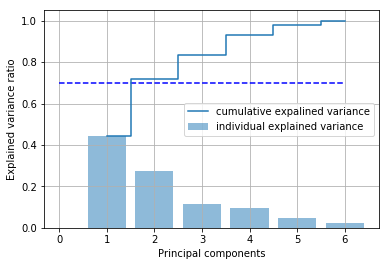

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(df_work10)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df_work10)
work10_pca = pca.transform(df_work10)
display(work10_pca)

array([[-1.75098532e+00, -7.05152286e-02],
       [-1.80036534e+00, -8.69753573e-01],
       [-1.89373597e+00, -1.67662072e+00],
       [ 1.12731297e+00, -1.45798229e+00],
       [-7.96711467e-01, -2.46086569e+00],
       [-1.08382370e+00, -3.92942430e-01],
       [-1.13261002e+00,  2.01601862e-01],
       [-1.58247377e+00, -9.68196420e-01],
       [-8.71825215e-01,  5.96758895e-01],
       [-2.88888315e+00, -7.41102520e-01],
       [-2.11616786e+00, -7.48845431e-01],
       [ 9.91451442e-01, -6.27014670e-02],
       [-2.23259521e+00, -1.32782770e+00],
       [-1.90404777e+00, -1.33385723e+00],
       [-2.33337847e+00, -9.83570924e-01],
       [ 4.17284069e-01,  8.14298928e-01],
       [-2.80513630e+00,  1.95322632e+00],
       [ 2.52569663e-01, -6.04494310e-01],
       [-1.40226890e+00, -1.86546557e+00],
       [-1.01598970e+00,  4.15101430e-01],
       [-8.36133270e-01, -1.14744897e+00],
       [ 1.72471835e+00,  1.47340654e-01],
       [-1.54938706e-01, -2.82992022e+00],
       [-2.

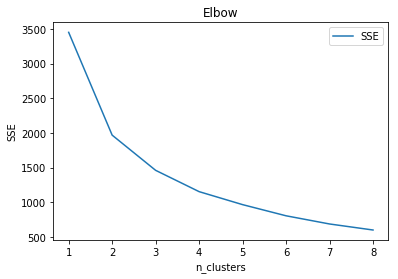

In [34]:
graph_elbow(work10_pca)

余り増やしすぎると判別しずらいので2個にクラスタリングする。

In [50]:
def learn_predict(X, model, print_y_pred=False):
    model.fit(X)
    y_pred = model.predict(X)
    if print_y_pred:
        print("y_pred =", y_pred)
    decision_cluster(X, y_pred, model)
    return y_pred
def decision_cluster(X, y, model):
    sc = plt.scatter(X[:,0], X[:,1], c=y)
    plt.colorbar(sc)
    plt.scatter(model.m_opt[:,0], model.m_opt[:,1], c="r", label="Center point")
    plt.legend()
    plt.show()


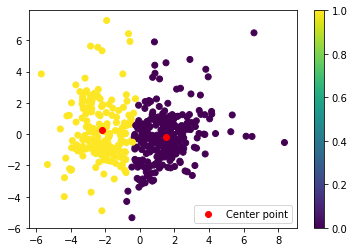

In [51]:
scratch_k_means2 = ScratchKMeans(n_clusters=2, n_init=10, max_iter=200, tol=1e-3, verbose=False)
y_pred_km = learn_predict(work10_pca, scratch_k_means2)
pass

### 【問題11】既知のグループとの比較 
RegionとChannelはK-meansに使用しなかったが、これらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

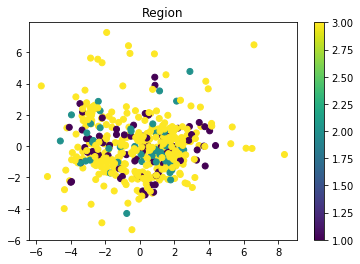

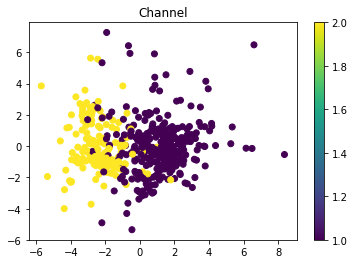

In [36]:
plt.title("Region")
sc = plt.scatter(work10_pca[:,0], work10_pca[:,1], c=df["Region"])
plt.colorbar(sc)
plt.show()

plt.title("Channel")
sc = plt.scatter(work10_pca[:,0], work10_pca[:,1], c=df["Channel"])
plt.colorbar(sc)
plt.show()

Channelは影響が強そう。地域差はあまりない

### 【問題12】卸売業者にとって有益な情報 
卸売業者にとって有益な情報を探し出し文章にまとめてください。

Description of Fresh


,count,mean,std,min,25%,50%,75%,max
False,178.0,8605.651685,11423.333014,3.0,2026.0,5339.5,11798.75,112151.0
True,262.0,14306.583969,12936.369897,3.0,5059.0,10724.5,19186.00,76237.0


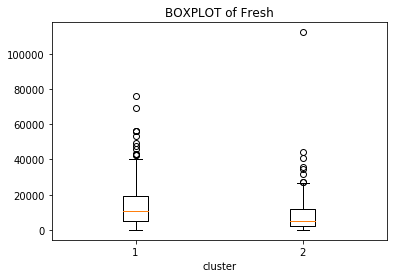

Description of Milk


,count,mean,std,min,25%,50%,75%,max
False,178.0,9972.252809,9141.957121,1115.0,5272.25,7529.5,11101.00,73498.0
True,262.0,2959.145038,3868.752082,55.0,1054.50,1916.5,3618.25,43950.0


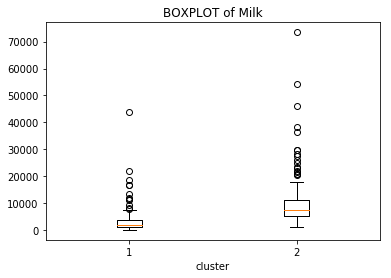

Description of Grocery


,count,mean,std,min,25%,50%,75%,max
False,178.0,14823.404494,11492.421673,2824.0,8028.75,11443.0,18667.75,92780.0
True,262.0,3282.427481,2871.018926,3.0,1642.75,2466.5,4029.75,20170.0


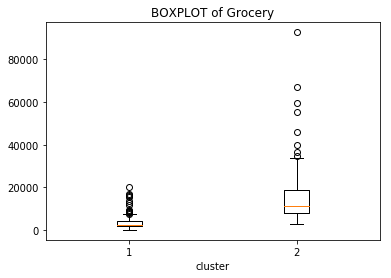

Description of Frozen


,count,mean,std,min,25%,50%,75%,max
False,178.0,1580.539326,1935.089668,25.0,419.00,1028.5,1904.75,16745.0
True,262.0,4085.167939,5878.266968,47.0,909.25,2282.5,5318.00,60869.0


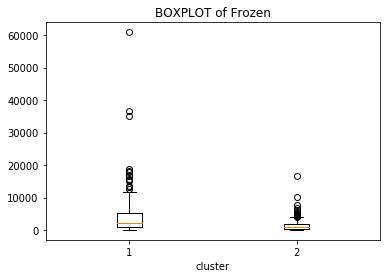

Description of Detergents_Paper


,count,mean,std,min,25%,50%,75%,max
False,178.0,6428.938202,5894.377892,223.0,2998.50,4606.5,7407.0,40827.0
True,262.0,471.396947,510.597459,3.0,168.25,322.0,625.5,4762.0


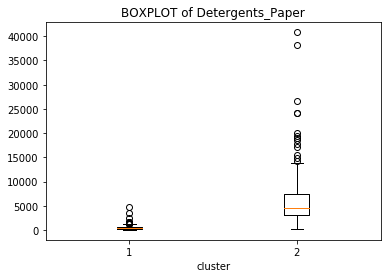

Description of Delicassen


,count,mean,std,min,25%,50%,75%,max
False,178.0,1772.882022,2128.102816,3.0,534.5,1311.5,2156.00,16523.0
True,262.0,1356.374046,3199.243980,3.0,383.0,804.0,1449.75,47943.0


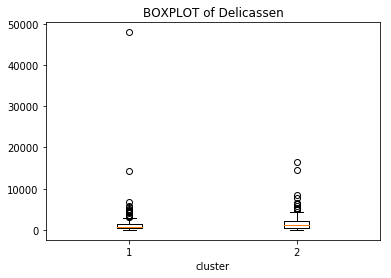

In [52]:
columns = df.iloc[:, (df.columns != "Channel") & (df.columns != "Region")].columns
display_table = True
for column in columns:
    print("Description of", column)
    if display_table:
        display(df[column].groupby(y_pred_km==0).describe())
    plt.boxplot([df.loc[y_pred_km==0, column], df.loc[y_pred_km==1, column]])
    plt.title("BOXPLOT of " + column)
    plt.xlabel("cluster")
    plt.show()

Detergents_PaperはCluster2の方が値が大きい。